In [1]:
import glob
import importlib
import json
import os
import pickle
from collections import Counter
from pathlib import Path
from typing import List, Tuple
from matplotlib.patches import Patch
import string

import joblib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import barplot
from tqdm.notebook import trange, tqdm

from cuml.manifold import TSNE, UMAP
import rdkit
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from scipy.sparse import csr_matrix
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
class BoostWrapper(object):
    """ Help joblib to deal with boost functions """

    def __init__(self, method_name, module_name):
        self.method_name = method_name
        self.module = importlib.import_module(module_name)

    @property
    def method(self):
        return getattr(self.module, self.method_name)

    def __call__(self, *args, **kwargs):
        return self.method(*args, **kwargs)
    

def smiles_to_mols(smiles, n_jobs=8):

    if isinstance(smiles, (list, tuple, np.ndarray)):
        pass
    elif isinstance(smiles, pd.Series):
        smiles = smiles.tolist()
    else:
        raise TypeError(f"{type(smiles)=}")

    assert len(smiles) > 0
    assert isinstance(smiles[0], str), f"expect smiles string, got f{smiles[0]}"

    mols = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(BoostWrapper('MolFromSmiles', 'rdkit.Chem.rdmolfiles', ))(smi) for smi in smiles)
    return mols


def smiles_to_fps(smiles_or_mols, finger_type='rdkit', n_jobs=8, fp_param=None):

    if isinstance(smiles_or_mols, (list, tuple, np.ndarray)):
        pass
    elif isinstance(smiles_or_mols, pd.Series):
        smiles_or_mols = smiles_or_mols.tolist()
    else:
        raise TypeError(f"{type(smiles_or_mols)=}")

    assert len(smiles_or_mols) > 0
    assert isinstance(smiles_or_mols[0], (str, rdkit.Chem.rdchem.Mol)), f"variable {smiles_or_mols[0]} has type {type(smiles_or_mols[0])}"

    if isinstance(smiles_or_mols[0], str):
        mols = smiles_to_mols(smiles_or_mols)
    else:
        mols = smiles_or_mols

    if fp_param is None:
        fp_param = {}
    fp_func, fp_func_name, fp_func_module, fp_params = _find_fingerprint_function(finger_type)
    fp_params.update(fp_param)
    if finger_type == 'morgan':
        fp_func = fp_func(**fp_params).GetFingerprint
        fp_params = {}
    fps = joblib.Parallel(n_jobs=n_jobs, prefer="threads")(
        joblib.delayed(fp_func)(mol, **fp_params) for mol in mols)
    return fps


def _find_fingerprint_function(finger_type: str) -> Tuple[callable, str, str, dict]:
    kwargs = {}
    if finger_type == 'rdkit':
        fp_func_name = 'RDKFingerprint'
        fp_func_module = 'rdkit.Chem'
    elif finger_type == 'maccs':
        fp_func_name = 'GetMACCSKeysFingerprint'
        fp_func_module = 'rdkit.Chem.rdMolDescriptors'
    elif finger_type == 'morgan':
        fp_func_name = 'GetMorganGenerator'
        fp_func_module = 'rdkit.Chem.AllChem'
        kwargs = dict(atomInvariantsGenerator=rdFingerprintGenerator.GetMorganFeatureAtomInvGen(),
                      radius=2, fpSize=2048, countSimulation=True)
    else:
        raise NotImplementedError(f"Use `rdkit` or `maccs` or `morgan` as fps")

    fp_func = getattr(importlib.import_module(fp_func_module), fp_func_name)
    return fp_func, fp_func_name, fp_func_module, kwargs

In [ ]:
def get_mols_dict(smi_list, gen_models_name, tanimoto_cutoff: int=0.6, n_mols_per_model: int=100):
    
    def validate_smile(smile):
        try:
            mol = Chem.MolFromSmiles(smile)
            Chem.SanitizeMol(mol)
            return Chem.MolToSmiles(mol, canonical=True)
        except Exception:
            return None
    
    for model_name in gen_models_name:
        tables_path = list(gene2file[model_name].values())
        
        for idx in range(len(tables_path)):
            gene_name = os.path.splitext(os.path.basename(tables_path[idx]))[0].split('_')[-1]
            tag = f'{gene2family[gene_name]} ({model_name})'
            smi_list[tag] = []

        for idx in trange(len(tables_path)):
            df_ = pd.read_csv(tables_path[idx])
            
            
            if 'Tanimoto' in df_.columns:
                df_ = df_[df_.Tanimoto <= tanimoto_cutoff]
            
            valid_smiles = [validate_smile(smile) for smile in df_.SMILES]
            df_['SMILES'] = valid_smiles
            df_ = df_.dropna(subset=['SMILES'])

            gene_name = os.path.splitext(os.path.basename(tables_path[idx]))[0].split('_')[-1]

            if len(df_) > n_mols_per_model:
                df_ = df_.sample(n_mols_per_model)
            smi = df_.SMILES.unique()
            tag = f'{gene2family[gene_name]} ({model_name})'
            smi_list[tag] += list(smi)
    return smi_list

In [5]:
def medmad(data, nstds, niter=2):
    def mask_1d(arr_1d):
        med_x = np.nanmedian(arr_1d)
        mad_x = np.nanmedian(np.fabs(arr_1d - med_x))
        mask = 0.6745 * np.fabs(arr_1d - med_x) / mad_x < nstds
        return mask

    if data.ndim not in [1, 2]:
        return None

    def get_mask(x):
        if x.ndim == 1:
            return mask_1d(x)
        elif x.ndim == 2:
            mask_md = np.ones_like(x, dtype=bool)
            for i, v in enumerate(x.T):
                mask_md[:, i] = mask_1d(v)
            return mask_md.all(axis=1)        

    nsamples = len(data)    
    indx = np.arange(nsamples, dtype=int)

    for i_iter in range(niter):
        mask_out = get_mask(data)
        indx = indx[mask_out]
        data = data[mask_out]

    mask = np.zeros(nsamples, dtype=bool)
    mask[indx] = True
    return mask

## Load data

In [6]:
base_path = Path(os.getcwd()).parent
chkpt_path = base_path / 'notebooks' / 'medusa_ckpnt'
save_dir = base_path / 'results' 
os.makedirs(save_dir, exist_ok=True)

In [ ]:
gene2file = {}
gen_models_list = ['protobind_diff', 'pocket2mol', 'pocketflow', 'targetdiff',  
               'reinvent', 'tamgen']
model_names = ['bindingdb_active'] + gen_models_list

for model_name in model_names:
    tables_path = glob.glob(str(base_path / f'data/{model_name}/generated_*.csv'))
    gene2file[model_name] = dict(zip([os.path.splitext(os.path.basename(tables_path[i]))[0].split('_')[-1] 
                                      for i in range(len(tables_path))], tables_path))

In [9]:
gene2family = {
    'ESR1': 'Nuclear receptor',
    'HCRTR1': 'Family A G protein-coupled receptor',
    'JAK1': 'Kinase',
    'RIOK1': 'Kinase',
    'NR4A1': 'Nuclear receptor',
    'GRIK1': 'Ligand-gated ion channel',
    'P2RX3': 'Ligand-gated ion channel',
    'IDH1': 'Oxidoreductase',
    'KDM1A': 'Eraser',
    'CCR9': 'Family A G protein-coupled receptor',
    'SPIN1': 'Reader',
    'FTO': 'Oxidoreductase'
}

family_list = ['Eraser', 'Family A G protein-coupled receptor', 'Kinase',
       'Ligand-gated ion channel', 'Nuclear receptor', 'Oxidoreductase',
       'Reader']

In [10]:
smi_list = {}

n_mols_per_model=1000
tanimoto_cutoff=0.5

smi_list = get_mols_dict(smi_list, gen_models_list,
                        tanimoto_cutoff=tanimoto_cutoff, 
                        n_mols_per_model=n_mols_per_model)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
smiles_to_fps_params = {'finger_type': 'morgan', 'fp_param': {'fpSize': 512, 'radius': 2}}

In [12]:
with open(chkpt_path / "umap_model.pkl", "rb") as f:
    umap_model = pickle.load(f)

# save UMAP transformed data
# update files every time the umap model is loaded
for family in tqdm(np.unique(np.array(family_list))):
    for model_name in gen_models_list:
        tag = f'{family} ({model_name})'
        s = tag.replace(' (', '_').replace(' ', '_').replace(')', '').replace('-', '_')
        new_fps = np.array(smiles_to_fps(smi_list[tag], **smiles_to_fps_params))
        tsne_2D = umap_model.transform(csr_matrix(new_fps))
        np.save(chkpt_path / s, tsne_2D, allow_pickle=False)

  0%|          | 0/7 [00:00<?, ?it/s]

## Train KNN Classifier

In [13]:
family_list = np.unique(np.array(family_list))
family2idx = dict(zip(family_list, np.arange(0, len(family_list))))
idx2family = dict(zip(np.arange(0, len(family_list)), family_list))
family2idx

{'Eraser': 0,
 'Family A G protein-coupled receptor': 1,
 'Kinase': 2,
 'Ligand-gated ion channel': 3,
 'Nuclear receptor': 4,
 'Oxidoreductase': 5,
 'Reader': 6}

In [ ]:
# Train KNN

# Define the resolution of the grid (step size), smaller h means finer resolution
h = 0.05
n_neighbors=50

X = []
labels = []
for family in family_list:
    tag = f'{family} (bindingdb_active)'
    s = tag.replace(' (', '_').replace(' ', '_').replace(')', '').replace('-', '_')
    data = np.load(chkpt_path /f'{s}.npy')
    X += list(data)
    labels += [family2idx[family]]*len(data)
X = np.array(X)
mask = medmad(X, 5, niter=2)
labels = np.array(labels)[mask]
X = X[mask]
unique_labels = np.unique(labels)
n_labels = len(unique_labels)
print(f'Number of points: {len(labels)}')

knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X, labels)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Number of points: 23693


In [15]:
def calc_accuracy_knn(model_name, knn):
    
    out = []
    X_b = []
    labels_b = []
    for family in family_list:
        tag = f'{family} ({model_name})'
        s = tag.replace(' (', '_').replace(' ', '_').replace(')', '').replace('-', '_')
        data = np.load(chkpt_path / f'{s}.npy')
        X_b += list(data)
        labels_b += [family2idx[family]]*len(data)
    X_b = np.array(X_b)
    mask = medmad(X_b, 5, niter=2)
    labels_b = np.array(labels_b)[mask]
    X_b = X_b[mask]

    unique_labels_b = np.unique(labels_b)
    n_labels_b = len(unique_labels_b)
    
    predicted_labels_b = knn.predict(X_b)
    label_counts_b = Counter(labels_b)

    for label in sorted(unique_labels_b):
        true_label_indices = np.where(labels_b == label)[0]
        correctly_predicted_count = np.sum(predicted_labels_b[true_label_indices] == label)
        total_label_count = label_counts_b[label]
        
        if total_label_count > 0:
            fraction_correct = correctly_predicted_count / total_label_count
            out.append(fraction_correct)
        else:
            print(f"Label {label}: No points found in Dataset B.")
    return out

In [ ]:
names_mapping = {
    'bindingdb_active': 'BindingDB',
    'protobind_diff': 'ProtoBind-Diff',
    'reinvent': 'REINVENT4',
    'pocket2mol': 'Pocket2Mol',
    'pocketflow': 'PocketFlow',
    'tamgen': 'TamGen',
    'targetdiff': 'TargetDiff'
}

family_names_mapping = {'Nuclear receptor': 'Transcription factor/Nuclear receptor (ESR1, NR4A1)',
 'Family A G protein-coupled receptor': 'Membrane receptor/GPCR (HCRTR1, CCR9)',
 'Kinase': 'Enzyme/Kinase (JAK1, RIOK1)',
 'Ligand-gated ion channel': 'Ion channel/Ligand-gated ion channel (GRIK1, P2RX3)',
 'Eraser': 'Epigenetic regulator/Eraser (KDM1A)',
 'Oxidoreductase': 'Enzyme/Oxidoreductase (IDH1, FTO)',
 'Reader': 'Epigenetic regulator/Reader (SPIN1)'}

In [21]:
def plot_contours(model_name, knn, xx, yy, Z, n_labels, axs, i):
    ax = axs[i]
    tab10_cmap = plt.get_cmap('tab10')
    custom_cmap = mcolors.ListedColormap(tab10_cmap(np.linspace(0, 1, 10))[:n_labels])
    levels = np.arange(-0.5, n_labels, 1)
    norm = mcolors.BoundaryNorm(levels, custom_cmap.N)
    
    X, labels = [], []
    for family in family_list:
        tag = f'{family} ({model_name})'
        s = tag.replace(' (', '_').replace(' ', '_').replace(')', '').replace('-', '_')
        data = np.load(chkpt_path / f'{s}.npy')
        X += list(data)
        labels += [family2idx[family]]*len(data)
    X = np.array(X)
    mask = medmad(X, 5, niter=2)
    labels = np.array(labels)[mask]
    X = X[mask]
    
    img = ax.contourf(xx, yy, Z, levels=levels, cmap=custom_cmap, norm=norm, alpha=0.3)
    ax.text(-0.25, 0.95, f'({string.ascii_lowercase[i]})', transform=ax.transAxes, size=14, weight='bold')
    ax.scatter(X[:, 0], X[:, 1], 
                c=labels,       
                facecolors='none',    
                cmap=custom_cmap, 
                s=3,       
                marker='o',
                alpha=0.8,
                linewidths=0.5) 
    if i==6:
        names_ = [family_names_mapping[i] for i in list(family2idx.keys())]
        tab10 = plt.get_cmap('tab10').colors[:len(names_)]
        colors = [(r, g, b, 0.8) for r, g, b in tab10]
        handles = [Patch(facecolor=col, edgecolor='none', label=name)
                   for col, name in zip(colors, names_)]
        fig.legend(
            handles=handles,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.04),
            ncol=3,
            prop={"size": 14},
            frameon=False
        )
    
    total_score = calc_accuracy_knn(model_name, knn)    
    scores = dict(zip(family2idx.keys(), np.asarray(total_score).round(2)))
    if model_name == 'protobind_diff':
        ax.text(0.03, 0.12, f'{names_mapping[model_name]}', 
                transform=ax.transAxes, size=14, weight='bold')
        ax.text(0.03, 0.03, f'k-NN score {np.asarray(total_score).mean():.2f}', 
                transform=ax.transAxes, size=14, weight='bold')
    else:
        ax.text(0.03, 0.12, f'{names_mapping[model_name]}', 
                transform=ax.transAxes, size=14)
        ax.text(0.03, 0.03, f'k-NN score {np.asarray(total_score).mean():.2f}', 
                transform=ax.transAxes, size=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.set_xlim((-4.5, 3.5))
    ax.set_ylim((-3.8, 3))
    return scores, img

L1/L2 family name
Membrane receptor/GPCR (HCRTR1, CCR9)                  0.43
Enzyme/Kinase (JAK1, RIOK1)                            0.36
Epigenetic regulator/Eraser (KDM1A)                    0.31
Transcription factor/Nuclear receptor (ESR1, NR4A1)    0.15
Enzyme/Oxidoreductase (IDH1, FTO)                      0.23
Epigenetic regulator/Reader (SPIN1)                    0.01
Ion channel/Ligand-gated ion channel (GRIK1, P2RX3)    0.04
Name: KNN score, dtype: float64


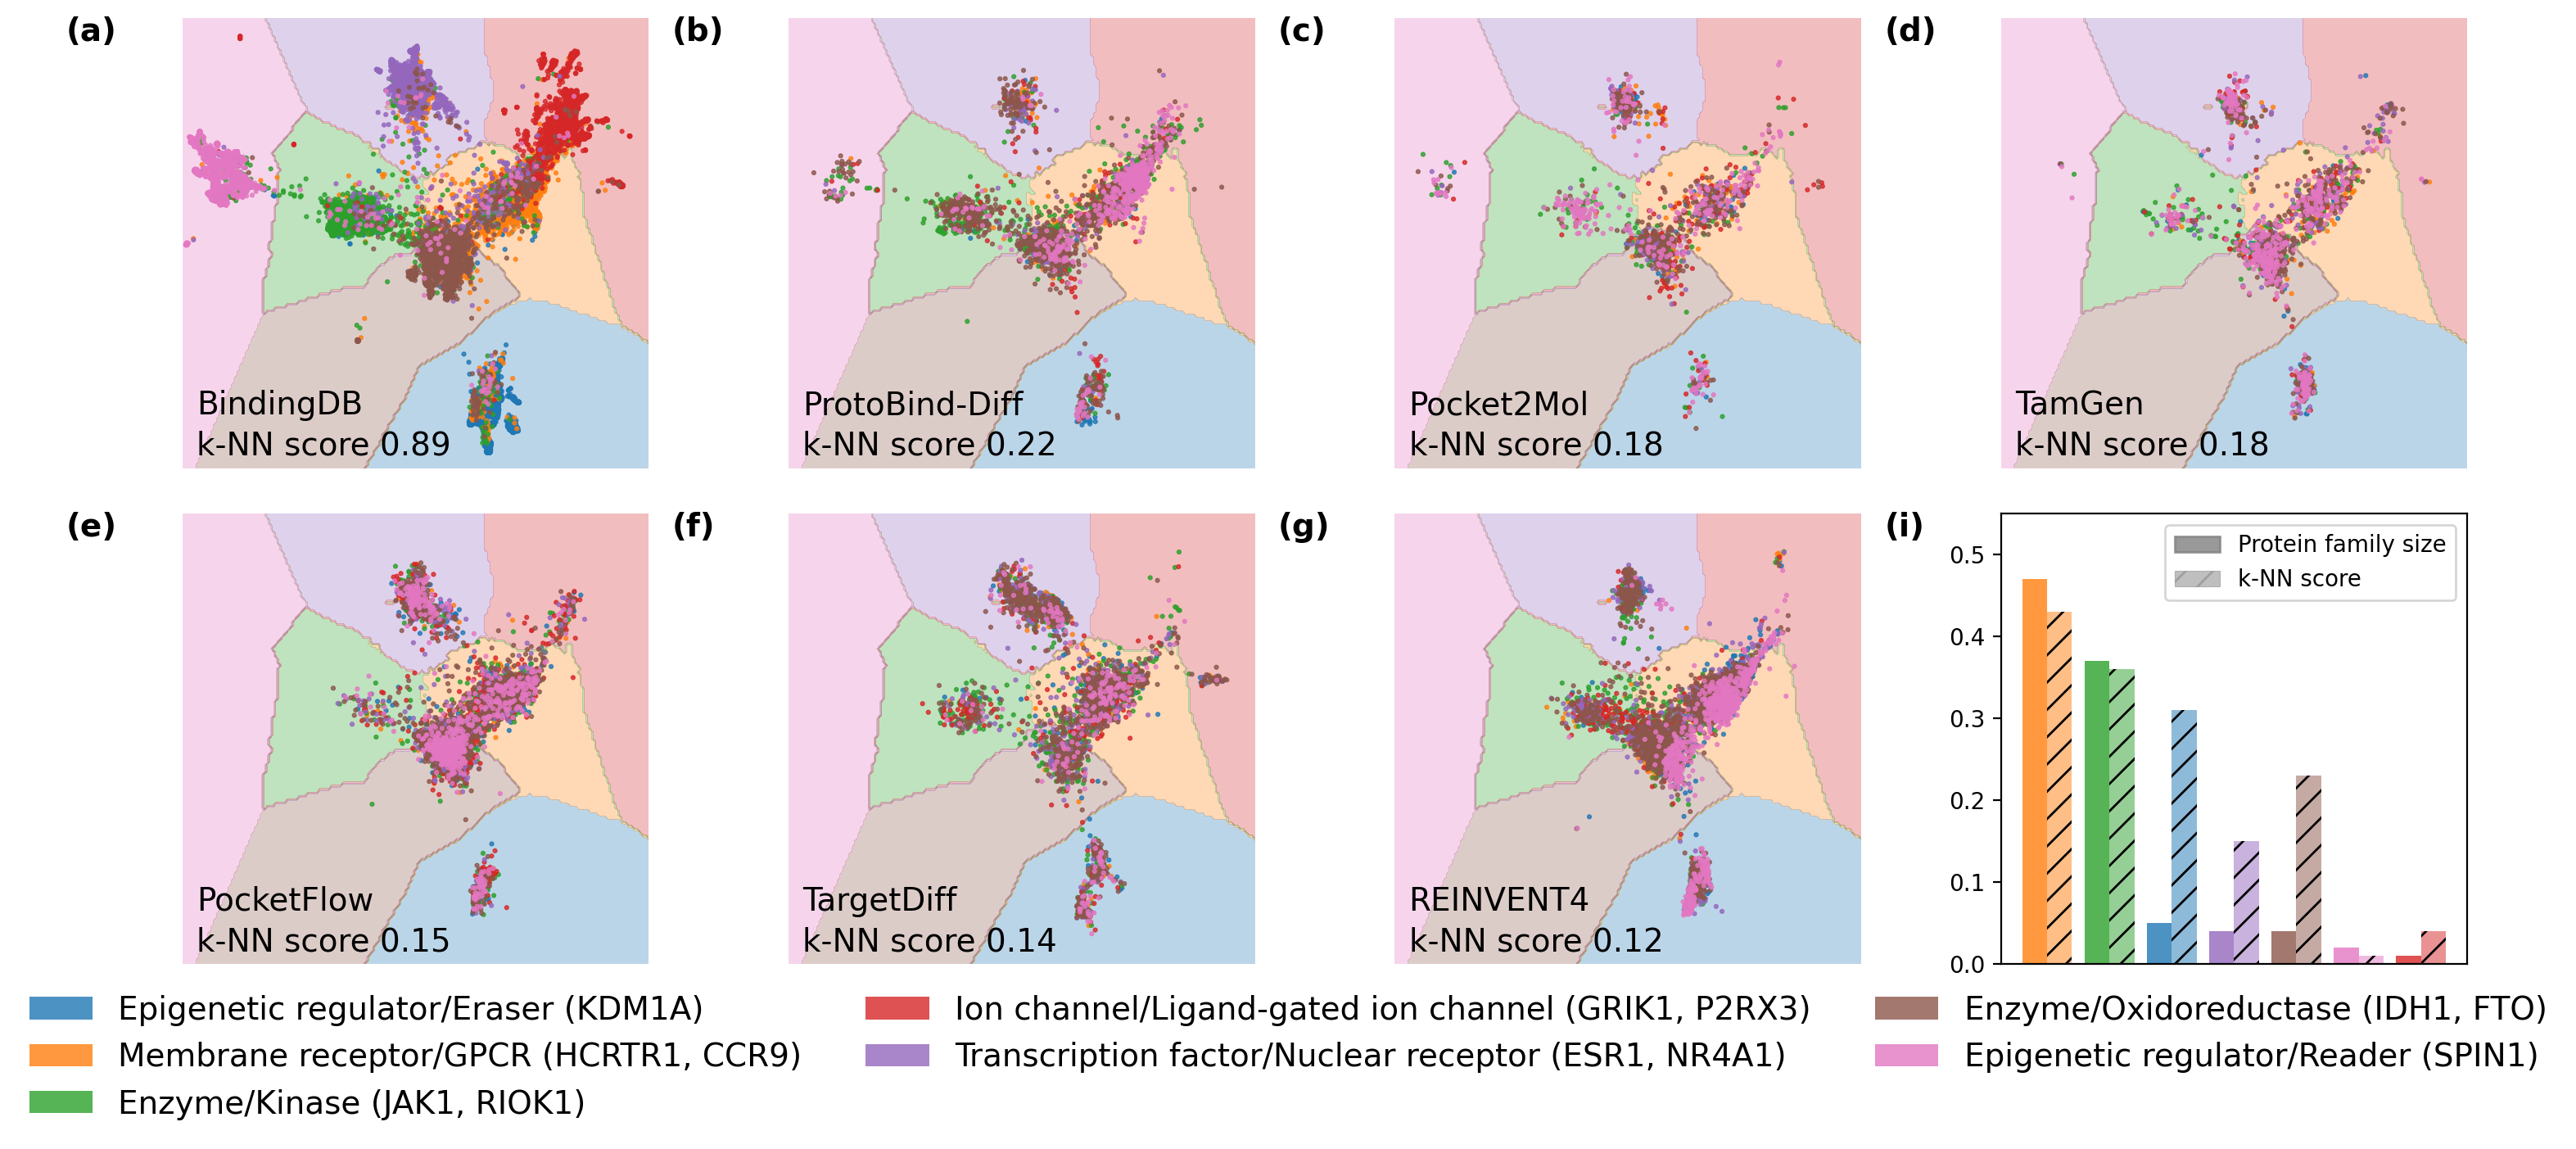

In [ ]:
model_list = [
    'bindingdb_active', 
    'protobind_diff',
    'pocket2mol',
    'tamgen',
    'pocketflow',
    'targetdiff',
    'reinvent',
]

fig, axs = plt.subplots(2, 4, figsize=(18, 7.5), dpi=200, gridspec_kw={'wspace': 0.3, 'hspace': 0.1})
axs = axs.flatten()

scores_all_models = {}
for i, model in enumerate(model_list):
    scores, img = plot_contours(model, knn, xx, yy, Z, n_labels, axs, i)
    scores_all_models[model] = list(scores.values())

families = list(scores.keys())

ax = axs[-1]
df = pd.read_csv(chkpt_path / f"UMAP_stats_bindingdb.csv")
df['KNN score'] = scores_all_models['protobind_diff']
df = df.sort_values('Number of samples in protein family', ascending=False)

x_labels = df['L1/L2 family name'].unique()
x = np.arange(len(x_labels))
samples = df.set_index('L1/L2 family name')['Number of samples in protein family'].reindex(x_labels)
knn_ = df.set_index('L1/L2 family name')['KNN score'].reindex(x_labels)

print(knn_)
bar_width = 0.4
palette = dict(zip([family_names_mapping[i] for i in families], sns.color_palette(n_colors=len(families))))
        
ax.bar(x - bar_width/2, samples, width=bar_width, color=[palette[l] for l in x_labels], alpha=0.8, 
       label='Protein family size')
bar = ax.bar(x + bar_width/2, knn_, width=bar_width, color=[palette[l] for l in x_labels], alpha=0.5, 
             label='k-NN score')
for patch in bar.patches:
    patch.set_hatch('//')
    patch.set_linewidth(0.4)  
ax.set_xticks([])
ax.set_ylabel('')
ax.text(-0.25, 0.95, f'({string.ascii_lowercase[len(model_list)+1]})', transform=ax.transAxes, size=14, weight='bold')
ax.legend()
ax.set_ylim((0, 0.55))
leg = ax.get_legend()
leg.legend_handles[0].set_facecolor('gray')
leg.legend_handles[0].set_edgecolor('gray')
leg.legend_handles[0].set_alpha(0.8)
leg.legend_handles[1].set_facecolor('gray')
leg.legend_handles[1].set_edgecolor('gray')
leg.legend_handles[1].set_alpha(0.5)

# fig.savefig(save_dir / f"UMAP.png", bbox_inches='tight')
plt.show();